In [1]:
{-# LANGUAGE FlexibleContexts, GADTs, TypeOperators #-}
import Data.Manifold.TreeCover
import Data.Manifold.Web
import Data.Manifold.Types
import Data.VectorSpace
import Data.AffineSpace
import Math.LinearMap.Category
import Data.Random
import Data.Random.Manifold

import Control.Arrow ((***))
import Control.Applicative (empty)
import Data.Foldable (toList, forM_)
import Data.Traversable (forM)

From [dynamic-plot](http://hackage.haskell.org/packages/dynamic-plot):

In [2]:
import Graphics.Dynamic.Plot.R2

From [diagrams](http://projects.haskell.org/diagrams):

In [3]:
import Diagrams.Prelude ( Point(P), r2, circle, (&), (#), (^.), (^&), _1, moveTo, opacity, red, blue, white, fromVertices )

Functions for plotting a 2D tree/web structures. Trees with lines for twigs and circles for leaves.

In [4]:
prettyTreePlot :: ShadeTree ℝ² -> [DynamicPlottable]
prettyTreePlot tr = [ plot [ shapePlot $ circle 0.03 & moveTo p & opacity 0.2 | p <- ps ]
                    , plot $ onlyNodes tr ]
 where ps = map P $ onlyLeaves tr
 
prettyWebPlot :: PointsWeb ℝ² () -> [DynamicPlottable]
prettyWebPlot w = [ shapePlot $ fromVertices [P r₁, P r₂] | ((r₁,()),(r₂,())) <- edg ]
 where edg = webEdges w

plotTreeAndWeb :: ShadeTree ℝ² -> IO ()
plotTreeAndWeb tr = do
    plotWindow $ prettyTreePlot tr # map (tint white)
              ++ prettyWebPlot (fromShadeTree (const euclideanNorm) tr)
                   # map (tweakPrerendered $ opacity 0.5)
    return ()

Simple cartesian grid within a disk:

In [5]:
cartTree :: ShadeTree ℝ²
cartTree = fromLeafPoints
              [ (x^&y) | x<-[0, 0.15 .. 4]
                       , y<-[0, 0.2 .. 4]
                       , (x-2)^2 + (y-2)^2 < 4 ]

plotTreeAndWeb cartTree

![visualisation of tree-cover and points-web of cartesian-disk cloud](https://raw.githubusercontent.com/leftaroundabout/manifolds/master/manifolds/images/examples/TreesAndWebs/2D-cartesiandisk.png)

<a id='pseudorandomCloudTree'></a>Cloud of 405 sort-of random points:

In [6]:
scatterTree = let
    tps₀ = [(0,0), (0,1), (1,1), (1,2), (2,2)]
    tps₁ = [p .+^ v^/3 | p<-tps₀, v <- [(0,0), (-1,1), (1,2)]]
    tps₂ = [p .+^ v^/4 | p<-tps₁, v <- [(0,0), (-1,1), (1,2)]]
    tps₃ = [p .+^ v^/5 | p<-tps₂, v <- [(0,0), (-2,1), (1,2)]]
    tps₄ = [p .+^ v^/7 | p<-tps₃, v <- [(0,1), (-1,1), (1,2)]]
     in fromLeafPoints $ r2<$>tps₄
plotTreeAndWeb scatterTree
((_,exampleTwiglet), exampleTwigEnviron) = twigsWithEnvirons scatterTree !! 5
plotWindow $ prettyTreePlot scatterTree
                 # map (tweakPrerendered (opacity 0.3) . tint white)
          ++ prettyTreePlot exampleTwiglet
                 # map (tint blue)
          ++ concat (prettyTreePlot . snd <$> exampleTwigEnviron)
                 # map (tweakPrerendered (opacity 0.3) . tint red)

GraphWindowSpecR2{lBound=-0.4156681133756531, rBound=2.7126549792593035, bBound=1.0424419331094115, tBound=3.5725506006237397, xResolution=640, yResolution=480}

![visualisation of tree-cover and points-wed of pseudorandom-point cloud](https://raw.githubusercontent.com/leftaroundabout/manifolds/master/manifolds/images/examples/ShadesAndWebs/2D-scatter.png)
![visualisation of a lowest-level twigs and its neighbours in the tree-cover of a pseudorandom-point cloud](https://raw.githubusercontent.com/leftaroundabout/manifolds/master/manifolds/images/examples/ShadesAndWebs/2D-scatter_twig-environs.png)

1000 actually-random, normally-distributed points<!--, with focus on one local point-group and its neighbours-->:

In [7]:
randomTr <- fmap fromLeafPoints . forM [0..1000] $ \_->
     runRVar (sample $ (1^&1):±[1^&0, 0^&1]) StdRandom :: IO ℝ²

-- ((_,twig),envi) <- runRVar (randomElement $ twigsWithEnvirons randomTr) StdRandom
-- plotWindow $ prettyTreePlot randomTr
--          ++ prettyTreePlot twig
--          ++ [plot $ prettyTreePlot.snd<$>envi]

plotTreeAndWeb randomTr

![visualisation of tree-cover and points-web of pseudorandom-point cloud](https://raw.githubusercontent.com/leftaroundabout/manifolds/master/manifolds/images/examples/TreesAndWebs/2D-normaldistrib.png)

In [8]:
cartWeb :: PointsWeb ℝ² ()
cartWeb = fromShadeTree (const euclideanNorm) cartTree

[(x, nearestNeighbour cartWeb (x^&1.6)) | x<-[1.7, 1.8 .. 2.2]]

[(1.7,Option {getOption = Just (V2 1.6499999999999992 1.6,())}),(1.8,Option {getOption = Just (V2 1.7999999999999992 1.6,())}),(1.9000000000000001,Option {getOption = Just (V2 1.949999999999999 1.6,())}),(2.0,Option {getOption = Just (V2 1.949999999999999 1.6,())}),(2.0999999999999996,Option {getOption = Just (V2 2.0999999999999988 1.6,())}),(2.1999999999999993,Option {getOption = Just (V2 2.2499999999999982 1.6,())})]

In [9]:
import Data.Graph
import Data.Graph.Inductive.PatriciaTree (Gr)
import Diagrams.TwoD.GraphViz
import Data.GraphViz

import Diagrams.Prelude ( p2, circle, (&), (^.), _1, moveTo, scale, opacity, fromVertices
                        , with, gaps, (.~), arrowShaft, unLoc, pathTrails
                        , place, arrowBetween', headLength, lc, grey )

convertGraph :: Graph -> Gr Int ()
convertGraph g = mkGraph (vertices g) [(v₁,v₂,()) | (v₁,v₂)<-edges g]

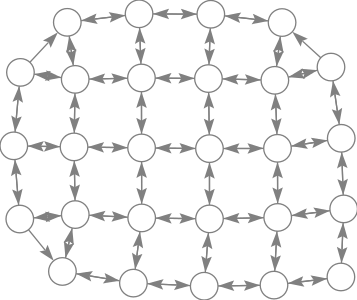

In [10]:
smallCartTree :: ShadeTree ℝ²
smallCartTree = fromLeafPoints
              [ (x^&y) | x<-[0, 0.7 .. 4]
                       , y<-[0, 0.6 .. 4]
                       , (x-2)^2 + (y-2)^2 < 4 ]

webGraph <- simpleGraphDiagram Neato . convertGraph
                    $ toGraph (fromShadeTree (const euclideanNorm) smallCartTree) ^. _1
                :: IO PlainGraphicsR2
webGraph & lc grey